<a href="https://colab.research.google.com/github/gachet/ad-1-24/blob/main/Multi_Class_Logistic_Regression_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi class logistic regression in numpy


Softmax regression, also called multinomial logistic regression extends [logistic regression](logistic_regression.ipynb) to multiple classes.

**Given:**
- dataset $\{(\boldsymbol{x}^{(1)}, y^{(1)}), ..., (\boldsymbol{x}^{(m)}, y^{(m)})\}$
- with $\boldsymbol{x}^{(i)}$ being a $d-$dimensional vector $\boldsymbol{x}^{(i)} = (x^{(i)}_1, ..., x^{(i)}_d)$
- $y^{(i)}$ being the target variable for $\boldsymbol{x}^{(i)}$, for example with $K = 3$ classes we might have $y^{(i)} \in \{0, 1, 2\}$

A softmax regression model has the following features:
- a separate real-valued weight vector $\boldsymbol{w}= (w^{(1)}, ..., w^{(d)})$ for each class. The weight vectors are typically stored as rows in a weight matrix.
- a separate real-valued bias $b$ for each class
- the softmax function as an activation function
- the cross-entropy loss function

The training procedure of a softmax regression model has different steps. In the beginning (step 0) the model parameters are initialized. The other steps (see below) are repeated for a specified number of training iterations or until the parameters have converged.

An illustration of the whole procedure is given below.

![title](figures/softmax_regression.jpg)

* * *
**Step 0: ** Initialize the weight matrix and bias values with zeros (or small random values).
* * *

**Step 1: ** For each class $k$ compute a linear combination of the input features and the weight vector of class $k$, that is, for each training example compute a score for each class. For class $k$ and input vector $\boldsymbol{x}^{(i)}$ we have:

$score_{k}(\boldsymbol{x}^{(i)}) = \boldsymbol{w}_{k}^T \cdot \boldsymbol{x}^{(i)} + b_{k}$

where $\cdot$ is the dot product and $\boldsymbol{w}_{(k)}$ the weight vector of class $k$.
We can compute the scores for all classes and training examples in parallel, using vectorization and broadcasting:

$\boldsymbol{scores} = \boldsymbol{X} \cdot \boldsymbol{W}^T + \boldsymbol{b} $

where $\boldsymbol{X}$ is a matrix of shape $(n_{samples}, n_{features})$ that holds all training examples, and $\boldsymbol{W}$ is a matrix of shape $(n_{classes}, n_{features})$ that holds the weight vector for each class.
* * *

**Step 2: ** Apply the softmax activation function to transform the scores into probabilities. The probability that an input vector $\boldsymbol{x}^{(i)}$ belongs to class $k$ is given by

$\hat{p}_k(\boldsymbol{x}^{(i)}) = \frac{\exp(score_{k}(\boldsymbol{x}^{(i)}))}{\sum_{j=1}^{K} \exp(score_{j}(\boldsymbol{x}^{(i)}))}$

Again we can perform this step for all classes and training examples at once using vectorization. The class predicted by the model for $\boldsymbol{x}^{(i)}$ is then simply the class with the highest probability.
* * *

** Step 3: ** Compute the cost over the whole training set. We want our model to predict a high probability for the target class and a low probability for the other classes. This can be achieved using the cross entropy loss function:

$J(\boldsymbol{W},b) = - \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^{K} \Big[ y_k^{(i)} \log(\hat{p}_k^{(i)})\Big]$

In this formula, the target labels are *one-hot encoded*. So $y_k^{(i)}$ is $1$ is the target class for $\boldsymbol{x}^{(i)}$ is k, otherwise $y_k^{(i)}$ is $0$.

Note: when there are only two classes, this cost function is equivalent to the cost function of [logistic regression](logistic_regression.ipynb).
* * *

** Step 4: ** Compute the gradient of the cost function with respect to each weight vector and bias. A detailed explanation of this derivation can be found [here](http://ufldl.stanford.edu/tutorial/supervised/SoftmaxRegression/).

The general formula for class $k$ is given by:

$ \nabla_{\boldsymbol{w}_k} J(\boldsymbol{W}, b) = \frac{1}{m}\sum_{i=1}^m\boldsymbol{x}^{(i)} \left[\hat{p}_k^{(i)}-y_k^{(i)}\right]$

For the biases, the inputs $\boldsymbol{x}^{(i)}$ will be given 1.
* * *

** Step 5: ** Update the weights and biases for each class $k$:

$\boldsymbol{w}_k = \boldsymbol{w}_k - \eta \, \nabla_{\boldsymbol{w}_k} J$  

$b_k = b_k - \eta \, \nabla_{b_k} J$

where $\eta$ is the learning rate.

## Multiclass logistic regression implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class MultiClassLogisticRegression:

    def __init__(self, n_iter = 10000, thres=1e-3):
        self.n_iter = n_iter
        self.thres = thres

    def fit(self, X, y, batch_size=64, lr=0.001, rand_seed=4, verbose=False):
        np.random.seed(rand_seed)
        self.classes = np.unique(y)
        self.class_labels = {c:i for i,c in enumerate(self.classes)}
        X = self.add_bias(X)
        y = self.one_hot(y)
        self.loss = []
        self.weights = np.zeros(shape=(len(self.classes),X.shape[1]))
        self.fit_data(X, y, batch_size, lr, verbose)
        return self

    def fit_data(self, X, y, batch_size, lr, verbose):
        i = 0
        while (not self.n_iter or i < self.n_iter):
            self.loss.append(self.cross_entropy(y, self.predict_(X)))
            idx = np.random.choice(X.shape[0], batch_size)
            X_batch, y_batch = X[idx], y[idx]
            error = y_batch - self.predict_(X_batch)
            update = (lr * np.dot(error.T, X_batch))
            self.weights += update
            if np.abs(update).max() < self.thres: break
            if i % 1000 == 0 and verbose:
                print(' Training Accuray at {} iterations is {}'.format(i, self.evaluate_(X, y)))
            i +=1

    def predict(self, X):
        return self.predict_(self.add_bias(X))

    def predict_(self, X):
        pre_vals = np.dot(X, self.weights.T).reshape(-1,len(self.classes))
        return self.softmax(pre_vals)

    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1,1)

    def predict_classes(self, X):
        self.probs_ = self.predict(X)
        return np.vectorize(lambda c: self.classes[c])(np.argmax(self.probs_, axis=1))

    def add_bias(self,X):
        return np.insert(X, 0, 1, axis=1)

    def get_randon_weights(self, row, col):
        return np.zeros(shape=(row,col))

    def one_hot(self, y):
        return np.eye(len(self.classes))[np.vectorize(lambda c: self.class_labels[c])(y).reshape(-1)]

    def score(self, X, y):
        return np.mean(self.predict_classes(X) == y)

    def evaluate_(self, X, y):
        return np.mean(np.argmax(self.predict_(X), axis=1) == np.argmax(y, axis=1))

    def cross_entropy(self, y, probs):
        return -1 * np.mean(y * np.log(probs))

## Implementation Evaluation

0.98


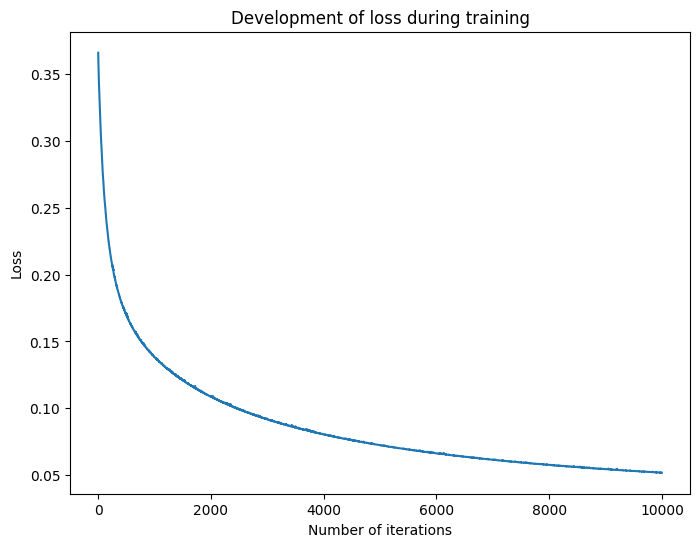

In [2]:
from sklearn import datasets
X,y = datasets.load_iris(return_X_y=True)
lr = MultiClassLogisticRegression(thres=1e-5)
lr.fit(X,y,lr=0.0001)
print(lr.score(X, y))

fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(len(lr.loss)), lr.loss)
plt.title("Development of loss during training")
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.show()

0.9654980523094046


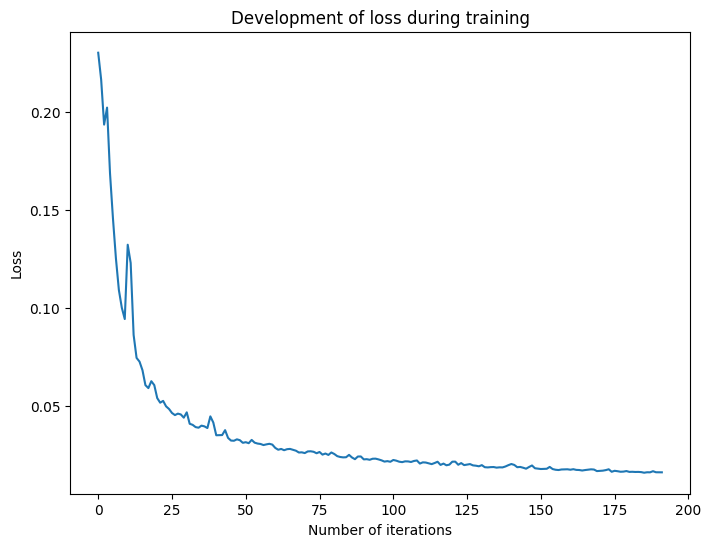

In [3]:
from sklearn import datasets
import matplotlib.pyplot as plt

# import some data to play with
digits = datasets.load_digits()
X = digits.data  # we only take the first two features.
Y = digits.target
lr = MultiClassLogisticRegression()
lr.fit(X,Y, lr=0.0001)

pre = lr.predict_classes(X)
print(lr.score(X,Y))

fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(len(lr.loss)), lr.loss)
plt.title("Development of loss during training")
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.show()

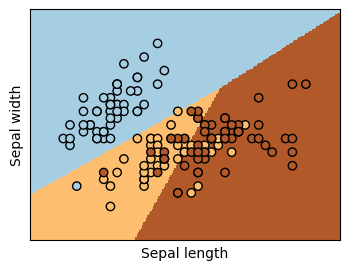

0.7866666666666666

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
Y = iris.target

logreg = MultiClassLogisticRegression()

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(X, Y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict_classes(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()
logreg.score(X, Y)

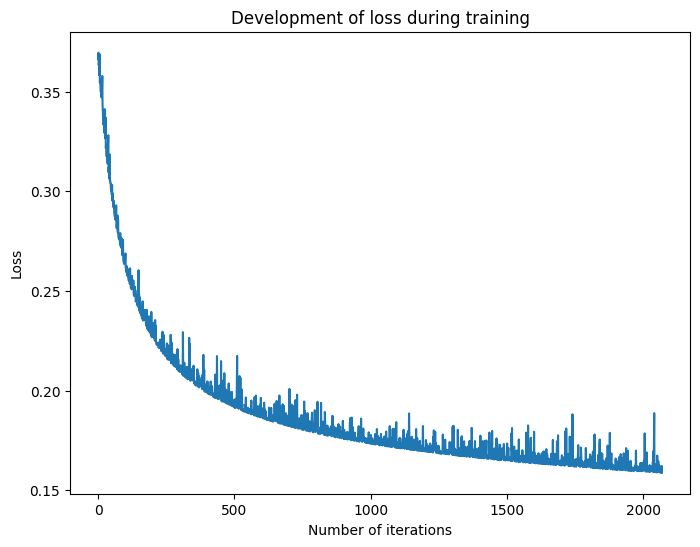

In [5]:
fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(len(logreg.loss)), logreg.loss)
plt.title("Development of loss during training")
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.show()